In [1]:
from __future__ import print_function
import numpy as np
from scipy.io import loadmat
import os
import glob
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline

print("import done")

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


import done


Create Datasets by randomly mixing 10min segments of preictal and interictal data.

In [3]:
#convert .mat data into ndarray and compress it usingle pickle
def mat_to_numpy(files):
    print('Reading files ' + files[0] + ' to ' + files[-1])
    nrfiles = len(files)
    placeholder_data = np.ndarray(shape=(nrfiles, 400*10*60, 16), dtype=np.float32)
    for idx, fl in enumerate(files):
        #open mat file
        mat = loadmat(fl)
        #convert from ndarray object to ndarray
        names = mat['dataStruct'].dtype.names
        ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
        #detect if columns out of order
        if not all(x<y for x, y in zip(ndata['channelIndices'][0], ndata['channelIndices'][0][1:])):
            print('WARNING: Columns out of order in file' + fl)
        placeholder_data[idx, :, :] = ndata['data']
    
    return placeholder_data

nrOfFiles = 30

def create_dataset(folder, name_pickle):
    #get files
    files_preictal = glob.glob(folder + "/*1.mat")
    files_interictal = glob.glob(folder + "/*0.mat")
    #randomize read files
    np.random.shuffle(files_preictal)
    np.random.shuffle(files_interictal)
    #read files into ndarrays
    data_preictal = mat_to_numpy(files_preictal[:nrOfFiles])
    labels_preictal = np.ones(data_preictal.shape[0], dtype=np.int32)
    data_interictal = mat_to_numpy(files_interictal[:nrOfFiles])
    labels_interictal = np.zeros(data_interictal.shape[0], dtype=np.int32)
    #concatenate preictal and interictal data
    data_merge = np.concatenate((data_preictal, data_interictal), axis=0)
    labels_merge = np.concatenate((labels_preictal, labels_interictal), axis=0)
    #shuffle data and labels mantaining relation between them
    shuffle_idx = np.random.permutation(data_merge.shape[0])
    data_merge = data_merge[shuffle_idx,:,:]
    labels_merge = labels_merge[shuffle_idx]
    #budle data and labels in dictionary
    save = {'data': data_merge, 'labels': labels_merge}
    try:
        with open(name_pickle, 'wb') as f:
            print('Pickling to ' + name_pickle)
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to' + name_pickle + ' :', e)
    
create_dataset('./train_1', 'trainsh2.pickle')

print('dataset done')

Reading files ./train_1/1_25_1.mat to ./train_1/1_35_1.mat
Reading files ./train_1/1_409_0.mat to ./train_1/1_360_0.mat
Pickling to trainsh2.pickle
dataset done


Load pickled dataset into memory.

In [4]:
name_pickle = 'trainsh1.pickle'

with open(name_pickle, 'rb') as f:
    print('Unpickling ' + name_pickle)
    load = pickle.load(f)
    dataset = load['data']
    labels = load['labels']
    del load
    print('Data loaded: shape', dataset.shape)

Unpickling trainsh1.pickle
Data loaded: shape (80, 240000, 16)


Plot some data to have an idea of how it looks like

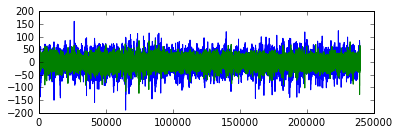

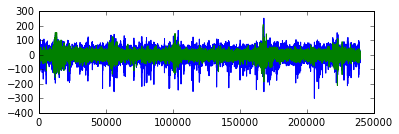

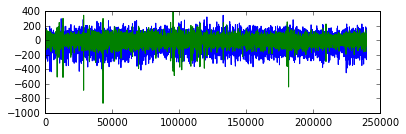

In [23]:
plt.subplot(211)
plt.plot(dataset[0,:,0])
plt.plot(dataset[0,:,8])

plt.figure(2)
plt.subplot(211)
plt.plot(dataset[23,:,0])
plt.plot(dataset[23,:,8])

plt.figure(3)
plt.subplot(211)
plt.plot(dataset[57,:,9])
plt.plot(dataset[57,:,5])

EEGNET implementation

Ideas
  - Condition classification based on sensor?

In [ ]:
#condition network 